In [3]:
import findspark
findspark.init()

In [4]:
import os
print("PATH: %s\n" % os.environ['PATH'])
print("SPARK_HOME: %s" % os.environ['SPARK_HOME'])

PATH: C:\Users\Lenovo\anaconda3;C:\Users\Lenovo\anaconda3\Library\mingw-w64\bin;C:\Users\Lenovo\anaconda3\Library\usr\bin;C:\Users\Lenovo\anaconda3\Library\bin;C:\Users\Lenovo\anaconda3\Scripts;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Python;C:\Python\Scripts;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Docker\Docker\resources\bin;C:\ProgramData\DockerDesktop\version-bin;C:\spark\spark-3.1.2-bin-hadoop2.7\bin;C:\Program Files\Java\jre1.8.0_301\bin;C:\Program Files\Git\cmd;C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps;C:\Program Files\JetBrains\PyCharm Community Edition 2021.2\bin;;

SPARK_HOME: C:\spark\spark-3.1.2-bin-hadoop2.7


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
spark = SparkSession \
        .builder \
        .appName("PySparkAnalysis") \
        .getOrCreate()

### load the sms_call_internet file

In [8]:
file1 = spark.read.load("/Users/Lenovo/Documents/pravin",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

In [9]:
file1.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



### there are many null values lets replace with zero

In [10]:
file1 = file1.na.fill(0)
file1.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



### create temp view in spark so that we can query data with spark sql

In [11]:
file1.createOrReplaceTempView("calldetailrecord")

In [15]:
###check table created or not
spark.sql("show tables").show()

+--------+----------------+-----------+
|database|       tableName|isTemporary|
+--------+----------------+-----------+
|        |calldetailrecord|       true|
+--------+----------------+-----------+



In [27]:
tt=spark.sql(''' select * from calldetailrecord''').show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



### calculate the sum of activity of sms,calls and internet usage for a group of countries.

In [14]:
groupbycountry = spark.sql("""select 
                                CASE countrycode
                                    WHEN 7 THEN "Russia"
                                    WHEN 33 THEN "France"
                                    WHEN 34 THEN "Spain"
                                    WHEN 39 THEN "Italy"
                                    WHEN 44 THEN "United Kingdom"
                                    WHEN 47 THEN "Norway"
                                    WHEN 48 THEN "Poland"
                                    WHEN 49 THEN "Germany"
                                    WHEN 351 THEN "Portugal"
                                    WHEN 420 THEN "Czech Republic"
                                    ELSE "_Others_"
                                END as country,
                                round(sum(smsin),6) sms_in, 
                                round(sum(smsout),6) sms_out, 
                                round(sum(callin),6) call_in, 
                                round(sum(callout),6) call_out, 
                                round(sum(internet),6) internet
                            from calldetailrecord
                            where countrycode != 0
                            group by country
                            order by 1
                            """)

In [26]:
groupbycountry.show(5)

+--------------+------------+------------+------------+------------+---------------+
|       country|      sms_in|     sms_out|     call_in|    call_out|       internet|
+--------------+------------+------------+------------+------------+---------------+
|Czech Republic|   2608.1169|   1437.8024|    733.0263|    544.2075|      5488.8842|
|        France|  20495.0177|  13158.3234|    4527.906|   2984.4441|     36769.9342|
|       Germany|   9549.2932|   2747.5518|   1960.2404|   1396.1923|     23737.9411|
|         Italy|2889250.3153|2688729.4971|2560497.8263|2962224.2957|8.22452086458E7|
|        Norway|    745.8405|    535.5974|    190.2444|    149.5543|       1913.018|
+--------------+------------+------------+------------+------------+---------------+
only showing top 5 rows



### filter rows using filter method 

In [25]:
#filter rows where countr code is 0
filter1= file1.filter(file1.countrycode==0)
print(filter1.show(3))

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     3|          0|0.3644|  null|  null| 0.0273|    null|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 3 rows

None


### group by cell id and count

In [30]:
aggre= file1.groupBy('CellID')
print(aggre.count().show(5))

+------+-----+
|CellID|count|
+------+-----+
|   296|  186|
|   467|   83|
|   675|   85|
|   691|  149|
|   829|   92|
+------+-----+
only showing top 5 rows

None


### visualization 

In [31]:
import matplotlib.pyplot as plt

In [32]:
#filter rows where country not in italy and others and convert spark data frame into pandas
df_pandas = groupbycountry.where("country not in ('Italy','_Others_')").toPandas()
print(df_pandas)

          country      sms_in     sms_out    call_in   call_out    internet
0  Czech Republic   2608.1169   1437.8024   733.0263   544.2075   5488.8842
1          France  20495.0177  13158.3234  4527.9060  2984.4441  36769.9342
2         Germany   9549.2932   2747.5518  1960.2404  1396.1923  23737.9411
3          Norway    745.8405    535.5974   190.2444   149.5543   1913.0180
4          Poland   3821.9876   1852.1156  1176.1172   861.9467   3879.9327
5        Portugal    616.0036    358.1073   288.9737   128.8219    459.4812
6          Russia   8983.6104   6108.6568  4682.9862  1710.7480   5509.7652
7           Spain   2301.3214   1428.7563  2178.4545  1665.4606  11389.0908
8  United Kingdom  11509.6936  11603.9780  3756.9092  2954.2486  23588.0875


<AxesSubplot:ylabel='country'>

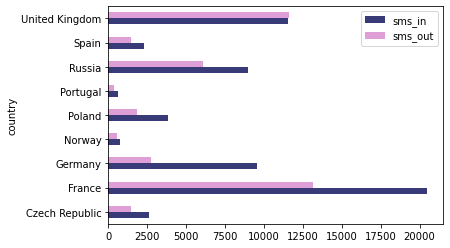

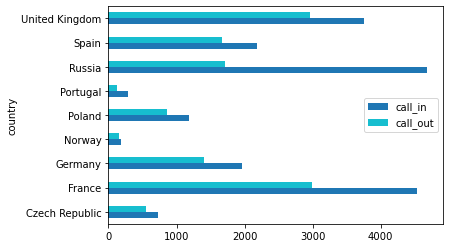

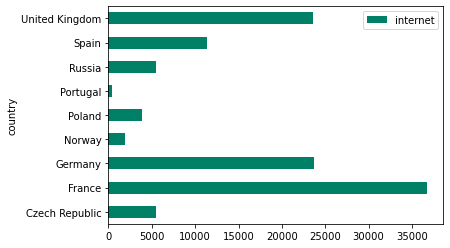

In [33]:
# plot country versus service activity 
df_pandas.plot(kind='barh', x='country', y=['sms_in', 'sms_out'], colormap='tab20b')
df_pandas.plot(kind='barh', x='country', y=['call_in', 'call_out'], colormap='tab10')
df_pandas.plot(kind='barh', x='country', y=['internet'], colormap='summer')